<a href="https://colab.research.google.com/github/park-geun-hyeong/Computer_Vision/blob/main/CH3/SSD_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Git Clone

In [ ]:
!git clone http://github.com/chulminkw/DLCV

## Library Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os
import time
from tqdm import tqdm

## Change Home directory for download

In [3]:
os.mkdir('/content/DLCV/SSD')
os.chdir('/content/DLCV/SSD')
os.getcwd()

'/content/DLCV/SSD'

##Pretrained_SSD_model download(backbone - inceptionNet)

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt


In [ ]:
!tar -xvf ssd_inception*.gz #tar.gz file 해제

In [7]:
! rm *.gz #zip file remove

In [8]:
! mv /content/DLCV/SSD/ssd_inception*.pbtxt  /content/DLCV/SSD/ssd_inception_v2_coco_2017_11_17/graph.pbtxt #move pbtxt file

In [9]:
os.listdir('/content/DLCV/SSD/ssd_inception_v2_coco_2017_11_17') #directory 확인

['model.ckpt.meta',
 'frozen_inference_graph.pb',
 'checkpoint',
 'graph.pbtxt',
 'saved_model',
 'model.ckpt.index',
 'model.ckpt.data-00000-of-00001']

## Make Model

In [10]:
model_weight_path = '/content/DLCV/SSD/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
model_config_path = '/content/DLCV/SSD/ssd_inception_v2_coco_2017_11_17/graph.pbtxt'

cv_net = cv2.dnn.readNetFromTensorflow(model_weight_path,model_config_path)

## Label Mapping(Tensorflow SSD- 1~91)

In [12]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


## Image Preprocessing

In [19]:
img_path = '/content/DLCV/data/image/beatles01.jpg'
img = cv2.imread(img_path) # imread method로 인해 array형태로 저장 

row = img.shape[0] #bounding box를 현재 image맞게 늘려주기 위해 필요
col = img.shape[1]

draw_img = img.copy()

cv_net.setInput(cv2.dnn.blobFromImage(img, size=(300,300), swapRB=True, crop=False )) ##SSD300은 image size를 (300,300)으로 맞춰줘야한다.
cv_out = cv_net.forward()

print('cv_out_shape: {}'.format(cv_out.shape))

cv_out_shape: (1, 1, 100, 7)


process_time: 0.0017


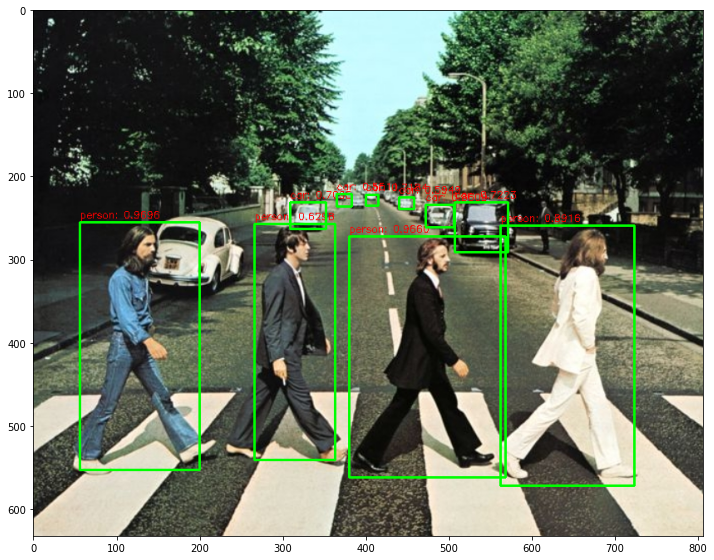

In [24]:
start= time.time()

green = (0,255,0)
red = (0,0,255)

for detection in cv_out[0,0,:,:]:
    classid = int(detection[1])
    score = float(detection[2])

    if score>0.5:
        left = int(detection[3]*col)
        top = int(detection[4]*row)
        right = int(detection[5]*col)
        bottom = int(detection[6]*row)

        caption = '{}: {:.4f}'.format(labels_to_names[classid],score)

        cv2.rectangle(draw_img, (left, top),(right,bottom), color=green, thickness=2)
        cv2.putText(draw_img, caption, (left,top-5),cv2.FONT_HERSHEY_SIMPLEX, 0.4,color=red, thickness=1)

print("process_time: {:.4f}".format(time.time()-start))

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
plt.show()

- cpu환경에서 8초정도 수행되었던 FasterRCNN model과 비교해보았을 때 수행시간이 엄청나게 빨라진 것을 확인할 수 있다.<br>(아쉽게도 가까운 차와 사람은 detect가 안되었다..)

## Functional

In [55]:
def create_img_detection(img_array, cv_net, threshold, copied_img=True):

    if copied_img:
        draw_img = img_array.copy()
    else:
        draw_img = img_array

    
    red = (0,0,255)
    green = (0,255,0)
    row = img_array.shape[0]
    col = img_array.shape[1]

    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300,300), swapRB=True, crop=False))
    cv_out = cv_net.forward()

    start = time.time()

    for detection in cv_out[0,0,:,:]:
        class_id = int(detection[1])
        score = float(detection[2])

        if score > threshold:
            left = int(detection[3]*col)
            top = int(detection[4]*row)
            right = int(detection[5]*col)
            bottom = int(detection[6]*row)

            caption = '{}: {:.4f}'.format(labels_to_names[class_id],score)
            cv2.rectangle(draw_img, (left,top), (right,bottom), color = green,thickness=2)
            cv2.putText(draw_img, caption, (left,top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=red, thickness=1)

    print('process_time: {:.4f}'.format(time.time() - start))

    return draw_img

process_time: 0.0007


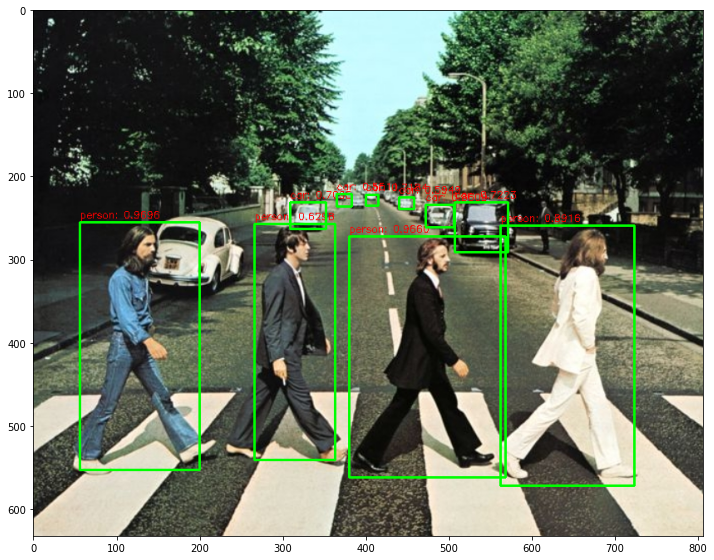

In [56]:
img = cv2.imread(img_path)
cv_net = cv2.dnn.readNetFromTensorflow(model_weight_path, model_config_path)


draw_img = create_img_detection(img, cv_net,0.5, copied_img=True)
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
plt.show()

##Examine Function through another image

process_time: 0.0005


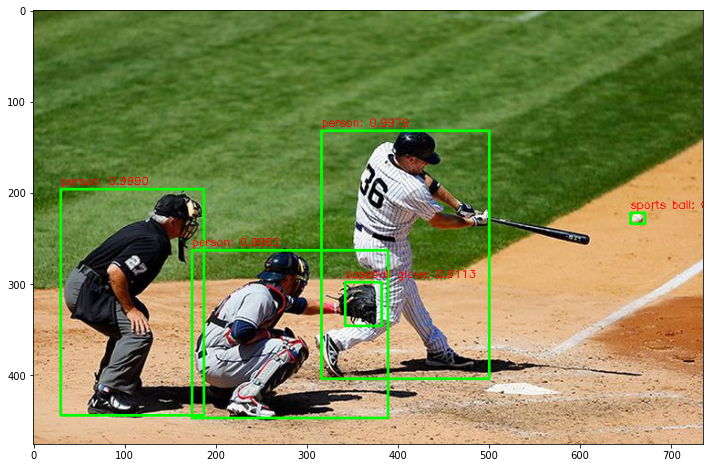

In [57]:
new_img = cv2.imread('/content/DLCV/data/image/baseball01.jpg')
cv_net = cv2.dnn.readNetFromTensorflow(model_weight_path, model_config_path)

draw_img = create_img_detection(new_img, cv_net, 0.5, True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
plt.show()

##Video Object Detection

In [58]:
os.listdir('/content/DLCV/data/video')

['John_Wick_small.mp4',
 'Night_Day_Chase.mp4',
 'jack_and_raccoon.mp4',
 'balloon_dog01.mp4',
 'balloon_dog02.mp4',
 'NFL01.mp4',
 'London_Street.mp4',
 'Pet_fight01.mp4',
 'FishnShark01.mp4',
 '.ipynb_checkpoints',
 'InfiniteWar01.mp4']

In [59]:
def video_object_detection(input_path, output_path, cv_net, threshold):
    
    cap = cv2.VideoCapture(input_path)
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('Frame_cnt :{}'.format(frame_cnt))

    out = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    while True:
        has_img, img_frame = cap.read()
        if not has_img:
            print('no more image to process')
            break

        return_frame = create_img_detection(img_frame, cv_net, threshold, False)
        out.write(return_frame)

    out.release()
    cap.release()    


In [60]:
vid_path = '/content/DLCV/data/video/John_Wick_small.mp4'
vid_output_path = '/content/DLCV/data/video/output_video.avi'
cv_net = cv2.dnn.readNetFromTensorflow(model_weight_path, model_config_path)

video_object_detection(vid_path, vid_output_path, cv_net, 0.4)

Frame_cnt :58
process_time: 0.0005
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0006
process_time: 0.0005
process_time: 0.0004
process_time: 0.0003
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0003
process_time: 0.0003
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0003
process_time: 0.0004
process_time: 0.0005
process_time: 0.0005
process_time: 0.0005
process_time: 0.0004
process_time: 0.0004
process_time: 0.0004
process_time: 0.0005
process_time: 0.0005
process_time: 0.0004
process_time: 0.0006
process_time: 0.0006
process_time: 0.0004
process_time: 0.0006
process_time: 0.0008
process_time: 0.0005
process_time: 0.0006
process_time: 0.0005
process_time: 0.0005
process_time: 0.0005
process_time: 0.0005
process_time: 0.0004